In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn as sns

## Original

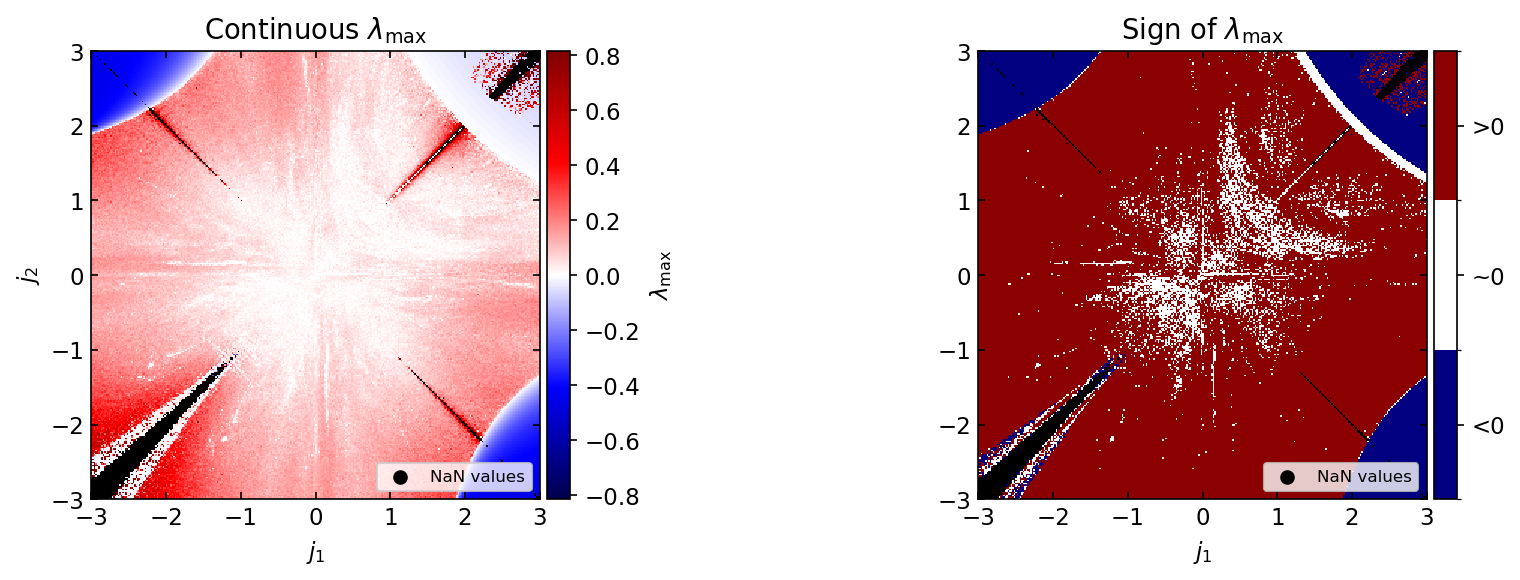

In [133]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# ---------- helper to load LLE data ----------
def load_lle_data(M_path, X_path, Y_path):
    M = np.loadtxt(M_path, delimiter=",")
    X = np.loadtxt(X_path, delimiter=",")
    Y = np.loadtxt(Y_path, delimiter=",")
    M_masked = np.ma.masked_invalid(M)

    finite_vals = M_masked.compressed()
    max_abs = np.max(np.abs(finite_vals)) if finite_vals.size > 0 else 1e-1
    vmax = max_abs/16
    vmin = -max_abs/16
    return M_masked, X, Y, vmin, vmax

# ---------- load only the JACOBIAN dataset (2nd one) ----------
M, X, Y, vmin, vmax = load_lle_data(
    "Data/M_LLE_jacobian.csv",
    "Data/X_LLE_jacobian.csv",
    "Data/Y_LLE_jacobian.csv"
)

# ---------- load periodic points ----------
px = py = None
try:
    px = np.loadtxt("periodic_px.csv", delimiter=",")
    py = np.loadtxt("periodic_py.csv", delimiter=",")
    if px.ndim == 0:
        px = np.array([px])
        py = np.array([py])
except OSError:
    pass

mpl.rcParams["font.size"] = 11

# ---------- colormaps ----------
sign_cmap = ListedColormap(["navy", "white", "darkred"])
sign_bounds = [-1.5, -0.5, 0.5, 1.5]
sign_norm = BoundaryNorm(sign_bounds, sign_cmap.N)

# classification cmap (unused now, but leaving for reference)
class_cmap = ListedColormap(["#1b9e77", "#d95f02", "#7570b3"])
class_bounds = [-0.5, 0.5, 1.5, 2.5]
class_norm = BoundaryNorm(class_bounds, class_cmap.N)

# ---------- build 1x2 figure ----------
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

# ============================================
# 1) Continuous Lyapunov Map
# ============================================
ax = axs[0]
cmap_cont = plt.get_cmap("seismic").copy()
cmap_cont.set_bad(color="black")   # <<< MAKE NaNs BLACK

im_cont = ax.imshow(
    M,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    aspect="equal",
    cmap=cmap_cont,
    vmin=vmin,
    vmax=vmax,
    interpolation="nearest",
)

ax.set_title(r"Continuous $\lambda_{\max}$")
ax.set_xlabel(r"$j_1$")
ax.set_ylabel(r"$j_2$")
ax.tick_params(direction="in", top=True, right=True)

# periodic points
if px is not None:
    ax.scatter(px, py, s=10, color="orange", edgecolors="k",
               linewidths=0.3, label=r"$|\lambda_{\max}|<10^{-3}$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im_cont, cax=cax).set_label(r"$\lambda_{\max}$")

# ============================================
# 2) Sign map
# ============================================
ax = axs[1]

eps = 10e-3
M_data = M.data
sign_map = np.zeros_like(M_data)
sign_map[M_data < -eps] = -1
sign_map[np.abs(M_data) <= eps] = 0
sign_map[M_data > eps] = 1
sign_masked = np.ma.array(sign_map, mask=M.mask)

# Make NaNs black
sign_cmap_local = sign_cmap.with_extremes(bad="black")

im_sign = ax.imshow(
    sign_masked,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    aspect="equal",
    cmap=sign_cmap_local,
    norm=sign_norm,
    interpolation="nearest",
)

ax.set_title(r"Sign of $\lambda_{\max}$")
ax.set_xlabel(r"$j_1$")
ax.tick_params(direction="in", top=True, right=True)

# periodic points
if px is not None:
    ax.scatter(px, py, s=10, color="orange", edgecolors="k", linewidths=0.3)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im_sign, cax=cax, ticks=[-1, 0, 1]).ax.set_yticklabels(["<0", "~0", ">0"])

# ============================================
# Add a legend explaining NaNs
# ============================================
for ax in axs:
    ax.scatter([], [], color="black", label="NaN values")
    ax.legend(loc="lower right", frameon=True, fontsize=8)

# ---------- layout & save ----------
fig.tight_layout()
fig.savefig("Plots/lyapunov_1x2_nanblack.png", dpi=300, bbox_inches="tight")
fig.savefig("Plots/lyapunov_1x2_nanblack.pdf", bbox_inches="tight")
plt.show()


In [139]:
j2_target = 2.0 

M shape: (300, 300)
X range: -3.0 3.0
Y range: -3.0 3.0
Rolling median window = 10 points


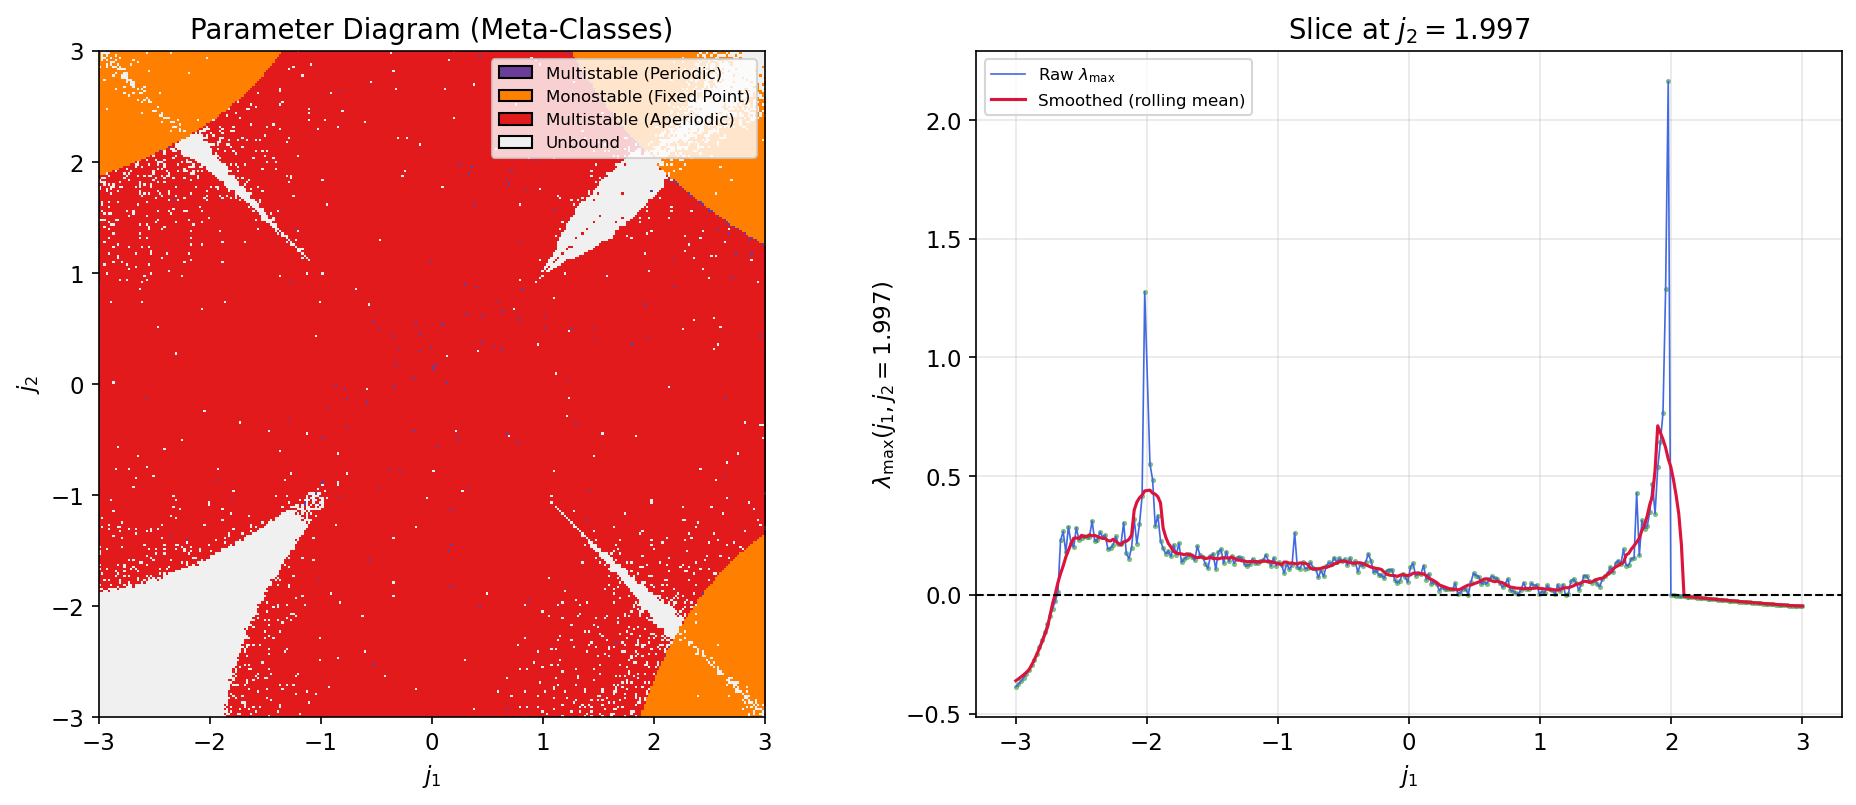

In [140]:
# ------------------------------------------------------
# Load class data (integer labels) for parameter diagram
# ------------------------------------------------------
M = np.loadtxt("Data/M.csv", delimiter=",", dtype=int)
X = np.loadtxt("Data/X.csv", delimiter=",")
Y = np.loadtxt("Data/Y.csv", delimiter=",")

print("M shape:", M.shape)
print("X range:", X.min(), X.max())
print("Y range:", Y.min(), Y.max())

# ------------------------------------------------------
# Re-group into 4 meta-classes
# ------------------------------------------------------
# 0: Unbound
# 1: Multistable (Periodic)      [Periodic + Quasiperiodic]
# 2: Monostable (Fixed Point)    [Fixed Point]
# 3: Multistable (Aperiodic)     [Chaotic / Irregular]

M_group = np.zeros_like(M, dtype=int)

# Multistable (Periodic) = periodic (1) + quasi-periodic (4)
M_group[(M == 1) | (M == 4)] = 1

# Monostable (Fixed Point) = fixed point (2)
M_group[M == 2] = 2

# Multistable (Aperiodic) = chaotic / irregular (5)
M_group[M == 5] = 3

# Everything else (0, 3, or any unexpected labels) stays 0 = Unbound

colors_grouped = [
    "#f0f0f0",  # 0: Unbound
    "#6a3d9a",  # 1: Multistable (Periodic)
    "#ff7f00",  # 2: Monostable (Fixed Point)
    "#e31a1c",  # 3: Multistable (Aperiodic)
]
cmap_grouped = mpl.colors.ListedColormap(colors_grouped)
bounds_grouped = np.arange(-0.5, 4.5, 1.0)  # for 0,1,2,3
norm_grouped = mpl.colors.BoundaryNorm(bounds_grouped, cmap_grouped.N)

# ------------------------------------------------------
# Load Lyapunov data for slice (continuous λ_max)
# ------------------------------------------------------
LLE = np.loadtxt("Data/M_LLE_jacobian.csv", delimiter=",")
LLE_masked = np.ma.masked_invalid(LLE)

# find closest index in the Y array
idx = np.argmin(np.abs(Y - j2_target))

# row idx in the LLE grid
lambda_slice = LLE_masked[idx, :]   # shape: (Nx,)
j1_vals = np.loadtxt("Data/X_LLE_jacobian.csv", delimiter=",")          

# clean out NaNs if present
if hasattr(lambda_slice, "mask"):
    mask = ~lambda_slice.mask
    j1_clean = j1_vals[mask]
    lambda_clean = lambda_slice[mask]
else:
    j1_clean = j1_vals
    lambda_clean = lambda_slice

# ------------------------------------------------------
# Smooth λ_max(j1) using a rolling median (robust to outliers)
# ------------------------------------------------------
# window_points controls how "wide" the smoothing window is
window_points = max(10, len(lambda_clean) // 50)  # ~2% of data, min 5 points

lambda_smooth = (
    pd.Series(lambda_clean)
    .rolling(window=window_points, center=True, min_periods=1)
    .mean()
    .to_numpy()
)

print(f"Rolling median window = {window_points} points")

# ------------------------------------------------------
# 1x2 FIGURE
# ------------------------------------------------------
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(13, 5.5), dpi=150)

# ------------------------------------------------------
# LEFT: parameter diagram with meta-classes
# ------------------------------------------------------
im = ax_left.imshow(
    M_group,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    cmap=cmap_grouped,
    norm=norm_grouped,
    aspect="equal",
    interpolation="nearest",
)

ax_left.set_xlabel(r"$j_1$")
ax_left.set_ylabel(r"$j_2$")
ax_left.set_title("Parameter Diagram (Meta-Classes)")

legend_elements = [
    Patch(facecolor="#6a3d9a", edgecolor="k", label="Multistable (Periodic)"),
    Patch(facecolor="#ff7f00", edgecolor="k", label="Monostable (Fixed Point)"),
    Patch(facecolor="#e31a1c", edgecolor="k", label="Multistable (Aperiodic)"),
    Patch(facecolor="#f0f0f0", edgecolor="k", label="Unbound"),
]
ax_left.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=True,
    fontsize=8,
)

# ------------------------------------------------------
# RIGHT: Lyapunov slice λ_max(j1, j2 = const) + smoothed version
# ------------------------------------------------------
# raw curve + scatter
ax_right.plot(
    j1_clean,
    lambda_clean,
    linewidth=0.8,
    color="royalblue",
    label=r"Raw $\lambda_{\max}$",
)
ax_right.scatter(
    j1_clean,
    lambda_clean,
    s=6,
    color="green",
    linewidths=0,
    alpha=0.5,
)

# smoothed curve
ax_right.plot(
    j1_clean,
    lambda_smooth,
    linewidth=1.5,
    color="crimson",
    label=r"Smoothed (rolling mean)",
)

ax_right.axhline(0, color="k", linestyle="--", linewidth=1)

ax_right.set_xlabel(r"$j_1$")
ax_right.set_ylabel(r"$\lambda_{\max}(j_1, j_2 = %.3f)$" % Y[idx])
ax_right.set_title(r"Slice at $j_2 = %.3f$" % Y[idx])

ax_right.grid(True, alpha=0.3)
ax_right.legend(loc="best", fontsize=8, frameon=True)

# ------------------------------------------------------
fig.tight_layout()
fig.savefig("Plots/parameter_and_LLE_slice(0-6).png", dpi=300, bbox_inches="tight")
fig.savefig("Plots/parameter_and_LLE_slice(0-6).pdf", bbox_inches="tight")

plt.show()


In [111]:
np.min(np.abs(M1_masked))

4.6465597873814716e-05

# Diagnotics

=== Diagnostic Summary ===
Total cells        : 90000
Valid LLE (0)      : 88207  (98.01 %)
Fail @ precheck (1): 1793  (1.99 %)
Fail @ LLE stage (2): 0  (0.00 %)



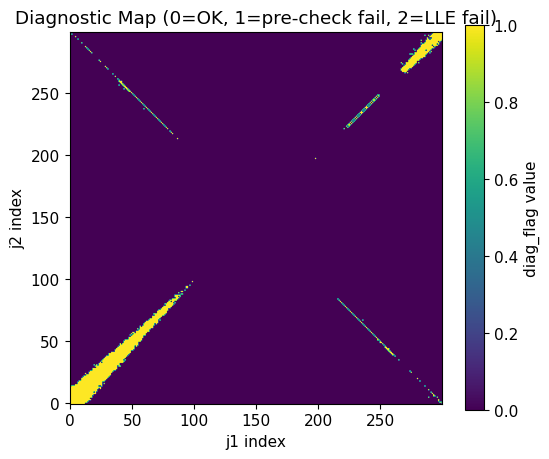

Number of pre-check failures: 1793
Number of LLE failures      : 0

First 10 pre-check failures (indices):
[]


In [112]:


# -----------------------------------------------------------
# 1. Load diagnostic matrix
# -----------------------------------------------------------
diag = np.loadtxt("Data/diag_flag_jacobian.csv", delimiter=",")

# Values meaning:
#   0 → LLE computed normally
#   1 → all ICs failed early pre-check (T_check)
#   2 → some ICs passed pre-check, but all failed during LLE
# -----------------------------------------------------------

# Count categories
n0 = np.sum(diag == 0)
n1 = np.sum(diag == 1)
n2 = np.sum(diag == 2)

total = diag.size

print("=== Diagnostic Summary ===")
print(f"Total cells        : {total}")
print(f"Valid LLE (0)      : {n0}  ({100*n0/total:.2f} %)")
print(f"Fail @ precheck (1): {n1}  ({100*n1/total:.2f} %)")
print(f"Fail @ LLE stage (2): {n2}  ({100*n2/total:.2f} %)")
print()

# -----------------------------------------------------------
# 2. Visualize the diagnostic matrix
# -----------------------------------------------------------

plt.figure(figsize=(6,5))
plt.imshow(diag, origin="lower", cmap="viridis")
plt.colorbar(label="diag_flag value")
plt.title("Diagnostic Map (0=OK, 1=pre-check fail, 2=LLE fail)")
plt.xlabel("j1 index")
plt.ylabel("j2 index")
plt.show()

# -----------------------------------------------------------
# 3. Get coordinates of problematic cells
# -----------------------------------------------------------

# Indices of each category
coords_precheck_fail = np.argwhere(diag == 1)
coords_lle_fail      = np.argwhere(diag == 2)

print("Number of pre-check failures:", coords_precheck_fail.shape[0])
print("Number of LLE failures      :", coords_lle_fail.shape[0])

# Show first few problematic points:
print("\nFirst 10 pre-check failures (indices):")
print(coords_lle_fail[:10])
